## Small simulated inputs

In [ ]:
import torch
from alphagenome_pytorch import AlphaGenome

model = AlphaGenome(num_organisms=3)

model.add_heads(
    'mouse',
    num_tracks_1bp = 1,
    num_tracks_128bp = 0,
    num_tracks_contacts = 0,
    num_splicing_contexts = 16, # 2 strands x num. conditions
)

model.add_heads(
    'human',
    num_tracks_1bp = 1,
    num_tracks_128bp = 0,
    num_tracks_contacts = 0,
    num_splicing_contexts = 14, # 2 strands x num. conditions
)

model.add_heads(
    'rat',
    num_tracks_1bp = 1,
    num_tracks_128bp = 0,
    num_tracks_contacts = 0,
    num_splicing_contexts = 14, # 2 strands x num. conditions
)


In [ ]:
# Create dummy DNA input
dna = torch.randint(0, 4, (3, 8192))

# Organism that each sequence belongs to
organism_index = torch.tensor([0, 1, 2])

# Define splice site positions (3 sites per sequence as example)
splice_donor_idx = torch.tensor([[10, 100, 200], [20, 150, 300], [30, 250, 350]])
splice_acceptor_idx = torch.tensor([[15, 105, 205], [25, 155, 305], [35, 255, 355]])

In [ ]:
# Get sequence embeddings
embeds_1bp, embeds_128bp, embeds_pair = model(
    dna, 
    organism_index=organism_index,
    return_embeds=True
)

In [ ]:
# Get track predictions
predictions = model(
    dna, 
    organism_index=organism_index,
    splice_donor_idx=splice_donor_idx,
    splice_acceptor_idx=splice_acceptor_idx
)

# predictions is a dict like: {'mouse': {'1bp_tracks': ..., 'splice_logits': ..., 'splice_usage': ..., 'splice_juncs': ...}}
for organism, outputs in predictions.items():
    for head_name, values in outputs.items():
        print(f"{organism} {head_name}: {values.shape}")

## Small input data subset

### Setup the model

In [ ]:
import os
import numpy as np
import torch
from alphagenome_pytorch import AlphaGenome

model = AlphaGenome(num_organisms=2)

model.add_heads(
    'human',
    num_tracks_1bp = 0,
    num_tracks_128bp = 0,
    num_tracks_contacts = 0,
    num_splicing_contexts = 7,
)

model.add_heads(
    'mouse',
    num_tracks_1bp = 0,
    num_tracks_128bp = 0,
    num_tracks_contacts = 0,
    num_splicing_contexts = 8,
)

#model.add_heads(
#    'rat',
#    num_tracks_1bp = 0,
#    num_tracks_128bp = 0,
#    num_tracks_contacts = 0,
#    num_splicing_contexts = 14,
#)

model.load_from_official_jax_model("all_folds", strict=False)

### Load processed data

In [ ]:
import os
import numpy as np
import pandas as pd
import json

def load_processed_data(mmap_dir):
    # Sequences
    meta_path = os.path.join(mmap_dir, 'metadata.json')
    with open(meta_path, 'r') as f:
        meta = json.load(f)
    seq_path = os.path.join(mmap_dir, 'sequences.mmap')
    seq_dtype = np.dtype(meta.get('sequences_dtype'))
    seq_shape = tuple(meta.get('sequences_shape'))
    sequences = np.memmap(seq_path, dtype=seq_dtype, mode='r', shape=seq_shape)
    context_size = meta.get('context_size', 0)
    sequences = sequences[:, context_size:-context_size]
    # Labels
    lbl_path = os.path.join(mmap_dir, 'labels.mmap')
    lbl_dtype = np.dtype(meta.get('labels_dtype'))
    lbl_shape = tuple(meta.get('labels_shape'))
    labels = np.memmap(lbl_path, dtype=lbl_dtype, mode='r', shape=lbl_shape)
    # Usage
    sse_path = os.path.join(mmap_dir, 'usage_sse.mmap')
    sse_dtype = np.dtype(meta.get('sse_dtype', 'float32'))
    sse_shape = tuple(meta.get('sse_shape'))
    sse = np.memmap(sse_path, dtype=sse_dtype, mode='r', shape=sse_shape)
    # Condition mask
    mask_path = os.path.join(mmap_dir, 'condition_mask.mmap')
    mask = np.memmap(mask_path, dtype=np.bool_, mode='r', shape=(sse_shape[0], sse_shape[2]))
    # Metadata
    meta_csv = pd.read_csv(os.path.join(mmap_dir, 'metadata.csv'))
    species = meta_csv['species_id']
    return sequences, labels, sse, species, mask, meta_csv

In [ ]:
import os
import numpy as np
import pandas as pd
import json

def load_processed_data(data_dir):
    # Sequences
    meta_path = os.path.join(data_dir, 'metadata.json')
    with open(meta_path, 'r') as f:
        meta = json.load(f)
    seq_path = os.path.join(data_dir, 'sequences.mmap')
    seq_dtype = np.dtype(meta.get('sequences_dtype'))
    seq_shape = tuple(meta.get('sequences_shape'))
    sequences = np.memmap(seq_path, dtype=seq_dtype, mode='r', shape=seq_shape)
    context_size = meta.get('context_size', 0)
    sequences = sequences[:, context_size:-context_size]
    # Labels
    lbl_path = os.path.join(data_dir, 'labels.parquet')
    labels_sparse = pd.read_parquet(lbl_path)
    # Usage
    sse_path = os.path.join(data_dir, 'usage.parquet')
    sse_sparse = pd.read_parquet(sse_path)
    # Metadata
    meta_csv = pd.read_csv(os.path.join(data_dir, 'metadata.csv'))
    species = meta_csv['species_id']
    return sequences, labels_sparse, sse_sparse, species, meta_csv


In [ ]:
mmap_dir='/home/elek/sds/sd17d003/Anamaria/splicevo/data_new/splits_small_5kb/mouse_human/train/'
sequences, labels_sparse, sse_sparse, species, meta_csv = load_processed_data(mmap_dir)
print(f"Sequences shape: {sequences.shape}")
print(f"Labels: {labels_sparse.head(10)}")
print(f"Usage: {sse_sparse.head(10)}")

Sequences shape: (27718, 5000, 4)
Labels:    sample_idx  position  label
0           0         0      1
1           0        54      1
2           0       299      2
3           0       435      1
4           0      2774      2
5           0      2893      1
6           1      2327      2
7           1      2502      1
8           2      2330      2
9           2      2505      1
Usage:    sample_idx  position  condition_idx  alpha  beta  sse
0           0         0              2    0.0   0.0  0.0
1           0         0              6    1.0   4.0  0.2
2           0      2893              2    0.0   0.0  0.0
3           0      2893              3    0.0   0.0  0.0
4           0      2893              7    0.0   1.0  0.0
5           0       435              0    0.0   1.0  0.0
6           0       299              2    0.0   0.0  0.0
7           0       299              6    2.0   3.0  0.4
8           0      2774              0    0.0   1.0  0.0
9           0      2774              1  

Convert loaded data to model input format

In [6]:
batch_size = 64  # Number of sequences to process

#### DNA sequences
Convert from one-hot to integer encoding: `sequences` is `(num_samples, seq_length, 4)` with binary 0/1 values for each nucleotide -- need to convert to `(num_samples, seq_length)` with values 0-3 for nucleotide encoding.

In [8]:
import torch 

seq_batch = sequences[:batch_size]  # (batch, seq_length, 4)
print(f"Original sequences shape: {seq_batch.shape}")

# Convert one-hot to integer: argmax along the nucleotide dimension (axis=2)
dna_full = torch.as_tensor(np.argmax(seq_batch, axis=2), dtype=torch.long)
print(f"DNA shape after one-hot conversion: {dna_full.shape}")

Original sequences shape: (64, 5000, 4)
DNA shape after one-hot conversion: torch.Size([64, 5000])


AlphaGenome requires sequence length to be power of 2 (e.g. 2^12=4096 or 2^13=8192).  
I will crop to 4096. Alternatively, could pad with Ns to reach 8192.

In [9]:
target_length = 4096
current_length = dna_full.shape[1]

if current_length < target_length:
    # Pad with zeros (or 'N' encoded as 0)
    padding = target_length - current_length
    dna = F.pad(dna_full, (0, padding), value=0)
elif current_length > target_length:
    # Center crop
    start = (current_length - target_length) // 2
    dna = dna_full[:, start:start + target_length]
else:
    dna = dna_full

print(f"DNA shape after padding/cropping to {target_length}: {dna.shape}")

DNA shape after padding/cropping to 4096: torch.Size([64, 4096])


#### Organism index
Map species IDs to organism indices: human=0, mouse=1, rat=2

In [10]:
species_mapping = {
    'human_GRCh37': 0,
    'mouse_GRCm38': 1, 
    'rat_Rnor_5.0': 2
}
organism_index = torch.tensor([species_mapping.get(s, 0) for s in species[:batch_size]])
print(f"Organism indices: {organism_index}")

Organism indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Splice site positions
Extract from labels and adjust for cropping: `labels` is `(num_samples, seq_length)` with splice site annotations, model expects: `(batch, num_sites)` with FIXED num_sites per batch.


In [12]:
# Calculate crop offset (used when converting from 5000 to 4096)
crop_start = (current_length - target_length) // 2 if current_length > target_length else 0
crop_end = crop_start + target_length if current_length > target_length else current_length
print(f"Crop start: {crop_start}, Crop end: {crop_end}")

max_donor_sites = 5
max_acceptor_sites = 5

splice_donor_idx = []
splice_acceptor_idx = []

# For debugging: track max number of sites seen in any sequence
max_donor_sites_seen = 0
max_acceptor_sites_seen = 0

labels_batch = labels_sparse[labels_sparse['sample_idx'] < batch_size]

for i in range(batch_size):
    label_seq = labels_batch[labels_batch['sample_idx'] == i]
    
    # Find donor (1) and acceptor (2) positions
    donor_pos = label_seq[label_seq['label'] == 1]['position'].values
    acceptor_pos = label_seq[label_seq['label'] == 2]['position'].values
    
    # Adjust positions for cropping: subtract crop_start offset
    # Only keep positions within the cropped range [crop_start, crop_end)
    donor_pos = donor_pos[(donor_pos >= crop_start) & (donor_pos < crop_end)] - crop_start
    acceptor_pos = acceptor_pos[(acceptor_pos >= crop_start) & (acceptor_pos < crop_end)] - crop_start
    
    # Ensure indices are within bounds [0, target_length)
    donor_pos = np.clip(donor_pos, 0, target_length - 1)
    acceptor_pos = np.clip(acceptor_pos, 0, target_length - 1)
    
    # Fallback if no splice sites found in cropped region
    if len(donor_pos) == 0:
        donor_pos = np.array([0])
    if len(acceptor_pos) == 0:
        acceptor_pos = np.array([0])
    
    # Track max sites seen for debugging
    max_donor_sites_seen = max(max_donor_sites_seen, len(donor_pos))
    max_acceptor_sites_seen = max(max_acceptor_sites_seen, len(acceptor_pos))

    # Pad by repeating last position
    donor_padded = np.pad(donor_pos[:max_donor_sites], 
                          (0, max(0, max_donor_sites - len(donor_pos))), 
                          mode='edge')[:max_donor_sites]
    acceptor_padded = np.pad(acceptor_pos[:max_acceptor_sites], 
                             (0, max(0, max_acceptor_sites - len(acceptor_pos))), 
                             mode='edge')[:max_acceptor_sites]
    
    splice_donor_idx.append(donor_padded)
    splice_acceptor_idx.append(acceptor_padded)

splice_donor_idx = torch.tensor(np.array(splice_donor_idx), dtype=torch.long)
splice_acceptor_idx = torch.tensor(np.array(splice_acceptor_idx), dtype=torch.long)

print(f"Splice donor indices shape: {splice_donor_idx.shape}")
print(f"Splice acceptor indices shape: {splice_acceptor_idx.shape}")
print(f"Example donors for first sequence (adjusted): {splice_donor_idx[0:5]}")
print(f"Example acceptors for first sequence (adjusted): {splice_acceptor_idx[0:5]}")
print(f"Max donor sites seen in a sequence: {max_donor_sites_seen}")
print(f"Max acceptor sites seen in a sequence: {max_acceptor_sites_seen}")

Crop start: 452, Crop end: 4548
Splice donor indices shape: torch.Size([64, 5])
Splice acceptor indices shape: torch.Size([64, 5])
Example donors for first sequence (adjusted): tensor([[2441, 2441, 2441, 2441, 2441],
        [2050, 2050, 2050, 2050, 2050],
        [2053, 2053, 2053, 2053, 2053],
        [ 785,  785,  785,  785,  785],
        [3473, 3473, 3473, 3473, 3473]])
Example acceptors for first sequence (adjusted): tensor([[2322, 2322, 2322, 2322, 2322],
        [1875, 1875, 1875, 1875, 1875],
        [1878, 1878, 1878, 1878, 1878],
        [ 666,  666,  666,  666,  666],
        [3348, 3348, 3348, 3348, 3348]])
Max donor sites seen in a sequence: 5
Max acceptor sites seen in a sequence: 5


#### Usage

First expand from sparse to dense format.

In [27]:
# Generate dense SSE usage matrix for the batch
n_conds = sse_sparse['condition_idx'].nunique()
sse_batch = sse_sparse[sse_sparse['sample_idx'] < batch_size]
sse = np.zeros((batch_size, current_length, n_conds), dtype=np.float32)
for _, row in sse_batch.iterrows():
    sample_idx = int(row['sample_idx'])
    position = int(row['position'])
    condition_idx = int(row['condition_idx'])
    sse_value = row['sse']
    sse[sample_idx, position, condition_idx] = sse_value

print(f"Original SSE usage shape: {sse.shape}")

Original SSE usage shape: (64, 5000, 8)


Also needs to be cropped to match sequence input length.

In [28]:
target_length = 4096
if current_length < target_length:
    # Pad with zeros (or 'N' encoded as 0)
    padding = target_length - current_length
    usage = F.pad(sse, (0, padding), value=0)
elif current_length > target_length:
    # Center crop
    start = (current_length - target_length) // 2
    usage = sse[:, start:start + target_length]
else:
    usage = sse

print(f"SSE usage shape after padding/cropping to {target_length}: {usage.shape}")

SSE usage shape after padding/cropping to 4096: (64, 4096, 8)


### Embeddings and predictions

Get embeddings

In [ ]:
# Get sequence embeddings
embeds_1bp, embeds_128bp, embeds_pair = model(
    dna, 
    organism_index=organism_index,
    return_embeds=True
)

Get predictions from model

In [ ]:
# Get track predictions
predictions = model(
    dna, 
    organism_index=organism_index,
    splice_donor_idx=splice_donor_idx,
    splice_acceptor_idx=splice_acceptor_idx
)

# predictions is a dict like: {'mouse': {'1bp_tracks': ..., 'splice_logits': ..., 'splice_usage': ..., 'splice_juncs': ...}}
for organism, outputs in predictions.items():
    for head_name, values in outputs.items():
        print(f"{organism} {head_name}: {values.shape}")

## Fine-tuning on the small processed data

Modify the model to start from pretrained model and continue training on my preprocessed data.

In [1]:
import yaml
from alphagenome_pytorch.config import AlphaGenomeConfig

# Config file
config_file = '../configs/splice_finetuning.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

# Path to training data
# data_dir = config.get('data_dir', '/home/elek/sds/sd17d003/Anamaria/splicevo//data/splits_small_5kb/mouse_human/train/')
data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo//data_new/splits_small_5kb/mouse_human/train/'

# Config params
seed = config.get('seed', 1950)
seq_len = config.get('seq_len', 4096)  # Must be power of 2
batch_size = config.get('batch_size', 4)
num_workers = config.get('num_workers', 4)
epochs = config.get('epochs', 3)
lr = config.get('lr', 1e-4)
validation_fraction = config.get('validation_fraction', 0.1)
max_donor_sites = config.get('max_donor_sites', 20)
max_acceptor_sites = config.get('max_acceptor_sites', 20)

# Load pretrained weights
load_pretrained = config.get('load_pretrained', False)
pretrained_model_version = config.get('pretrained_model_version', 'all_folds')
freeze_backbone = config.get('freeze_backbone', False)

# Load pretrained model configuration
default_cfg = AlphaGenomeConfig()
model_cfg = config.get('model', {})
dims = tuple(model_cfg.get('dims', default_cfg.dims))
basepairs = model_cfg.get('basepairs', default_cfg.basepairs)
dna_embed_width = model_cfg.get('dna_embed_width', default_cfg.dna_embed_width)
num_organisms = model_cfg.get('num_organisms', default_cfg.num_organisms)
transformer_kwargs = model_cfg.get('transformer_kwargs', default_cfg.transformer_kwargs)

# Hardcoded heads configuration for splicing-only tasks
heads_cfg = {
    'human': {
        'num_tracks_1bp': 0,
        'num_tracks_128bp': 0,
        'num_tracks_contacts': 0,
        'num_splicing_contexts': 7
    },
    'mouse': {
        'num_tracks_1bp': 0,
        'num_tracks_128bp': 0,
        'num_tracks_contacts': 0,
        'num_splicing_contexts': 8
    }
}

Dataset

In [2]:
%load_ext autoreload
%autoreload 2
import os
import json
from alphagenome_pytorch import SpliceDataset

# Load species mapping from metadata.json
metadata_path = os.path.join(data_dir, 'metadata.json')
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

species_mapping = metadata.get('species_mapping', {
    'human': 0,
    'mouse': 1,
    'rat': 2
})

print(f"Species mapping: {species_mapping}")

target_length = 4096
max_donor_sites = 20
max_acceptor_sites = 20
num_organisms = len(species_mapping)

train_dataset = SpliceDataset(
    data_dir=data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

Species mapping: {'human': 0, 'mouse': 1}
Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo//data_new/splits_small_5kb/mouse_human/train/


Architecture

In [3]:
from alphagenome_pytorch import AlphaGenome

model = AlphaGenome(dims, basepairs, dna_embed_width, num_organisms, transformer_kwargs)

# Add splicing heads only (no tracks or contact maps)
for organism, head_cfg in heads_cfg.items():
    model.add_heads(organism=organism, **head_cfg)

print("Total model parameters:", model.total_parameters)

Total model parameters: 405516192


/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


In [4]:
# Load pretrained weights if specified
if load_pretrained:
    print(f"Loading pretrained weights from {pretrained_model_version}...")
    model.load_from_official_jax_model(pretrained_model_version, strict=False)
    print("Pretrained weights loaded successfully")
    
    # Optionally freeze backbone
    if freeze_backbone:
        print("Freezing transformer backbone...")
        for param in model.transformer_unet.parameters():
            param.requires_grad = False
        
        # Keep heads trainable
        for organism, heads in model.heads.items():
            for head in heads.values():
                for param in head.parameters():
                    param.requires_grad = True
        
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters (heads only): {trainable_params:,}")

Loading pretrained weights from all_folds...


/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No GPU available, using CPU device: TFRT_CPU_0
Loading checkpoint (model_version=all_folds)...


Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 152983.73it/s]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


  Loaded 589 parameter arrays
  Loaded 81 state arrays

Converting 545 parameter mappings...
Converting 81 state mappings...

Converted 653 tensors to PyTorch state_dict
Pretrained weights loaded successfully
Freezing transformer backbone...
Trainable parameters (heads only): 12,272,153


Split into train and validation (stratified by species)

In [5]:
import numpy as np

dataset_size = len(train_dataset)
val_size = int(dataset_size * validation_fraction)
train_size = dataset_size - val_size

# Get species labels for stratified split
species_labels = []
for idx in range(dataset_size):
    species_id = train_dataset.species.iloc[idx]
    # If it is integer, use directly, otherwise if string (species name), map to index
    if isinstance(species_id, (int, np.integer)):
        organism_idx = int(species_id)
    else:
        organism_idx = train_dataset.species_mapping.get(species_id, 0)
    species_labels.append(organism_idx)
species_labels = np.array(species_labels)

In [6]:
from torch.utils.data import Subset

# Stratified split - ensure each species is represented proportionally
train_indices = []
val_indices = []

for organism_idx in np.unique(species_labels):
    # Get all indices for this organism
    org_indices = np.where(species_labels == organism_idx)[0]
    n_org = len(org_indices)
    n_val_org = int(n_org * validation_fraction)
    
    # Shuffle within organism
    np.random.shuffle(org_indices)
    
    # Split
    val_indices.extend(org_indices[:n_val_org])
    train_indices.extend(org_indices[n_val_org:])


# Shuffle the combined indices
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

# Create subset datasets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

In [7]:
# Print species distribution
train_species = species_labels[train_indices]
val_species = species_labels[val_indices]
print(f"Dataset split: {len(train_indices)} train, {len(val_indices)} validation")
for organism_idx in np.unique(species_labels):
    organism_name = [k for k, v in species_mapping.items() if v == organism_idx]
    organism_name = organism_name[0] if organism_name else f"organism_{organism_idx}"
    train_count = np.sum(train_species == organism_idx)
    val_count = np.sum(val_species == organism_idx)
    print(f"  {organism_name}: {train_count} train, {val_count} val")

Dataset split: 24947 train, 2771 validation
  human: 14101 train, 1566 val
  mouse: 10846 train, 1205 val


In [8]:
from torch.utils.data import DataLoader
from alphagenome_pytorch.samplers import SpeciesGroupedSampler

train_sampler = SpeciesGroupedSampler(train_subset, batch_size=batch_size, shuffle=True)
val_sampler = SpeciesGroupedSampler(val_subset, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(
    train_subset,
    batch_sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_sampler=val_sampler,
    num_workers=num_workers,
    pin_memory=True
)

Optimizer

In [9]:
import torch

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
    weight_decay=0.01
)

In [10]:
from accelerate import Accelerator

# prepare accelerator for distributed
accelerate_kwargs = {}
accelerator = Accelerator(**accelerate_kwargs)
model, train_loader, val_loader, optimizer = accelerator.prepare(model, train_loader, val_loader, optimizer)
device = accelerator.device

Loss functions

In [11]:
import torch.nn as nn
from alphagenome_pytorch import JunctionsLoss

# losses for splicing tasks only
loss_fns = {
    'splice_logits': nn.CrossEntropyLoss(),
    'splice_usage': nn.CrossEntropyLoss(),
    'splice_juncs': JunctionsLoss()
}

A function to train one epoch

In [12]:
def get_organism_name(organism_idx, species_mapping):
    """Map organism index to organism name used in model heads"""
    # Invert species_mapping to go from index to name
    for name, idx in species_mapping.items():
        if idx == organism_idx:
            return name
    return f'organism_{organism_idx}'

def exists(v):
    return v is not None


In [13]:
def train_one_epoch(model, dataloader, optimizer, loss_fns, device, species_mapping, accelerator: Accelerator | None = None):
    model.train()
    total_loss = 0.0
    total_splice_logits_loss = 0.0
    total_splice_usage_loss = 0.0
    total_splice_juncs_loss = 0.0
    num_batches = 0

    for batch in dataloader:
        # Move inputs to device
        dna = batch['dna'].to(device)
        organism_index = batch['organism_index'].to(device)
        splice_donor_idx = batch['splice_donor_idx'].to(device)
        splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)
        context_indices_map = batch['conditions_mask'].to(device)
        
        # Targets
        splice_labels = batch['splice_labels'].to(device)  # (batch, seq_len)
        splice_usage_target = batch['splice_usage_target'].to(device)  # (batch, seq_len, num_contexts)

        # Forward pass
        preds = model(
            dna,
            organism_index,
            splice_donor_idx=splice_donor_idx,
            splice_acceptor_idx=splice_acceptor_idx
        )
        
        # Since batches are species-specific, preds should only contain one organism
        # assert len(preds) == 1, f"Expected 1 organism in batch, got {len(preds)}"
        # But the model actually calculates predictions for both species
        # so I will only use predictions for batch species for loss calculation

        # Compute losses for batch organism
        losses = []
        batch_organism = organism_index.unique().tolist()
        for org_name, org_preds in preds.items():
            # Skip organisms not in this batch
            if org_name not in [get_organism_name(org_idx, species_mapping) for org_idx in batch_organism]:
                continue
            # Splice logits loss (5-class classification: none, donor, acceptor, etc.)
            if 'splice_logits' in org_preds:
                splice_logits = org_preds['splice_logits']  # (batch, seq_len, 5)
                # Reshape for cross entropy
                splice_logits_flat = splice_logits.reshape(-1, splice_logits.shape[-1])
                splice_labels_flat = splice_labels.reshape(-1)
                splice_logits_loss = loss_fns['splice_logits'](splice_logits_flat, splice_labels_flat)
                losses.append(splice_logits_loss)
                total_splice_logits_loss += splice_logits_loss.item()
            
            # Splice usage loss (per-context usage prediction)
            if 'splice_usage' in org_preds:
                splice_usage = org_preds['splice_usage']  # (batch, seq_len, num_contexts_for_organism)
            
                # Get which SSE columns this organism uses
                sse_columns = context_indices_map[0]  # Get first element since all in batch are same organism
                
                # Since batches are species-specific, all sequences are from this organism
                # Select only the relevant SSE columns for this organism
                org_sse_target = splice_usage_target[:, :, sse_columns]  # (batch, seq_len, num_contexts_for_organism)
                
                # Only compute loss at splice site positions (labels != 0)
                splice_site_mask = splice_labels != 0  # (batch, seq_len)
                
                if splice_site_mask.any():
                    # Select only splice site positions
                    splice_usage_at_sites = splice_usage[splice_site_mask]  # (num_sites, num_contexts)
                    org_sse_target_at_sites = org_sse_target[splice_site_mask]  # (num_sites, num_contexts)
                    
                    # Check for NaN/Inf in targets and replace with zeros
                    if torch.isnan(org_sse_target_at_sites).any() or torch.isinf(org_sse_target_at_sites).any():
                        org_sse_target_at_sites = torch.nan_to_num(org_sse_target_at_sites, nan=0.0, posinf=1.0, neginf=0.0)
                    
                    # Skip if predictions contain NaN
                    if not (torch.isnan(splice_usage_at_sites).any() or torch.isinf(splice_usage_at_sites).any()):
                        # Compute MSE loss
                        splice_usage_loss = loss_fns['splice_usage'](splice_usage_at_sites, org_sse_target_at_sites)
                        
                        if not torch.isnan(splice_usage_loss):
                            losses.append(splice_usage_loss)
                            total_splice_usage_loss += splice_usage_loss.item()

            
            # Splice junction loss (donor-acceptor pairings)
            if 'splice_juncs' in org_preds:
                splice_juncs = org_preds['splice_juncs']  # (batch, num_donors, num_acceptors, num_contexts)
                # Create target junction matrix (placeholder - adjust based on your data)
                # For now, use a simple loss
                splice_juncs_loss = loss_fns['splice_juncs'](splice_juncs, splice_juncs)  # Placeholder
                losses.append(splice_juncs_loss * 0)  # Weight down for now
                total_splice_juncs_loss += splice_juncs_loss.item()

        if len(losses) == 0:
            continue
            
        loss = torch.stack(losses).sum()

        # Backpropagation
        if exists(accelerator):
            accelerator.backward(loss)
        else:
            loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        num_batches += 1    

    avg_loss = total_loss / max(num_batches, 1)    
    avg_splice_juncs_loss = total_splice_juncs_loss / max(num_batches, 1)
    avg_splice_logits_loss = total_splice_logits_loss / max(num_batches, 1)    
    avg_splice_usage_loss = total_splice_usage_loss / max(num_batches, 1)
    
    return avg_loss, avg_splice_logits_loss, avg_splice_usage_loss, avg_splice_juncs_loss

A function to run validation epoch

In [14]:
@torch.no_grad()
def validate_one_epoch(model, val_loader, loss_fns, species_mapping, accelerator=None, device='cuda'):
    """Run validation and return average loss."""
    model.eval()
    
    total_loss = 0.0
    total_splice_logits_loss = 0.0
    total_splice_usage_loss = 0.0
    total_splice_juncs_loss = 0.0
    num_batches = 0

    for batch in val_loader:
        dna = batch['dna'].to(device)
        organism_index = batch['organism_index'].to(device)
        splice_donor_idx = batch['splice_donor_idx'].to(device)
        splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)
        splice_labels = batch['splice_labels'].to(device)
        splice_usage_target = batch['splice_usage_target'].to(device)
        context_indices_map = batch['conditions_mask'].to(device)

        # Forward pass
        preds = model(
            dna,
            organism_index=organism_index,
            splice_donor_idx=splice_donor_idx,
            splice_acceptor_idx=splice_acceptor_idx
        )

        # Compute losses for batch organisms only
        losses = []
        batch_organism = organism_index.unique().tolist()
        
        for org_name, org_preds in preds.items():
            # Skip organisms not in this batch
            if org_name not in [get_organism_name(org_idx, species_mapping) for org_idx in batch_organism]:
                continue
            # Splice logits loss
            if 'splice_logits' in org_preds:
                splice_logits = org_preds['splice_logits']
                splice_logits_flat = splice_logits.reshape(-1, splice_logits.shape[-1])
                splice_labels_flat = splice_labels.reshape(-1)
                splice_logits_loss = loss_fns['splice_logits'](splice_logits_flat, splice_labels_flat)
                losses.append(splice_logits_loss)
                total_splice_logits_loss += splice_logits_loss.item()
            
            # Splice usage loss
            if 'splice_usage' in org_preds:
                splice_usage = org_preds['splice_usage']  # (batch, seq_len, num_contexts_for_organism)
            
                # Get which SSE columns this organism uses
                sse_columns = context_indices_map[0]  # Get first element since all in batch are same organism
                
                # Since batches are species-specific, all sequences are from this organism
                # Select only the relevant SSE columns for this organism
                org_sse_target = splice_usage_target[:, :, sse_columns]  # (batch, seq_len, num_contexts_for_organism)
                
                # Only compute loss at splice site positions (labels != 0)
                splice_site_mask = splice_labels != 0  # (batch, seq_len)
                
                if splice_site_mask.any():
                    # Select only splice site positions
                    splice_usage_at_sites = splice_usage[splice_site_mask]  # (num_sites, num_contexts)
                    org_sse_target_at_sites = org_sse_target[splice_site_mask]  # (num_sites, num_contexts)
                    
                    # Check for NaN/Inf in targets and replace with zeros
                    if torch.isnan(org_sse_target_at_sites).any() or torch.isinf(org_sse_target_at_sites).any():
                        org_sse_target_at_sites = torch.nan_to_num(org_sse_target_at_sites, nan=0.0, posinf=1.0, neginf=0.0)
                    
                    # Skip if predictions contain NaN
                    if not (torch.isnan(splice_usage_at_sites).any() or torch.isinf(splice_usage_at_sites).any()):
                        # Compute MSE loss
                        splice_usage_loss = loss_fns['splice_usage'](splice_usage_at_sites, org_sse_target_at_sites)
                        
                        if not torch.isnan(splice_usage_loss):
                            losses.append(splice_usage_loss)
                            total_splice_usage_loss += splice_usage_loss.item()
            
            # Splice junction loss
            if 'splice_juncs' in org_preds:
                splice_juncs = org_preds['splice_juncs']
                splice_juncs_loss = loss_fns['splice_juncs'](splice_juncs, splice_juncs)
                losses.append(splice_juncs_loss * 0)
                total_splice_juncs_loss += splice_juncs_loss.item()

        if len(losses) > 0:
            loss = torch.stack(losses).sum()
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / max(num_batches, 1)
    avg_splice_logits_loss = total_splice_logits_loss / max(num_batches, 1)  
    avg_splice_usage_loss = total_splice_usage_loss / max(num_batches, 1)    
    avg_splice_juncs_loss = total_splice_juncs_loss / max(num_batches, 1)
    
    return avg_loss, avg_splice_logits_loss, avg_splice_usage_loss, avg_splice_juncs_loss


Run training for fixed number of epochs.

In [17]:
save_path = "/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/small_mouse_human_5kb/finetune_splice_heads.pt"

def save_model(model, optimizer, epoch, path):
    torch.save({
        'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, path)

In [15]:
print(f"\nStarting training for {epochs} epochs...")
print(f"Train size: {train_size}, Validation size: {val_size}")
print(f"Train batches per epoch: {len(train_loader)}")

epochs=10
patience=5
epochs_without_improvement=0

for epoch in range(epochs):
    avg_train_loss, splice_logits_loss, splice_usage_loss, splice_juncs_loss = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fns=loss_fns,
        species_mapping=species_mapping,
        accelerator=accelerator,
        device=device
    )
    msg = f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} "
    msg += f"(Logits: {splice_logits_loss:.4f} | "
    msg += f"Usage: {splice_usage_loss:.4f} )"

    # Run validation
    avg_val_loss, val_logits_loss, val_usage_loss, val_juncs_loss = validate_one_epoch(
        model=model,
        val_loader=val_loader,
        loss_fns=loss_fns,
        species_mapping=species_mapping,
        accelerator=accelerator,
        device=device
    )
    msg += f"Val Loss: {avg_val_loss:.4f} "
    msg += f"(Splice: {val_logits_loss:.4f} | "
    msg += f"Usage: {val_usage_loss:.4f})"
    print(msg)
    
    if avg_val_loss < best_val_loss:
        print(f"  Validation loss improved by {best_val_loss - avg_val_loss:.4f}, saved best model: {save_path}")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        save_model(model, optimizer, epoch + 1, save_path)
    else:
        epochs_without_improvement += 1
    

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs (no improvement for {patience} epochs)")
        break

    accelerator.wait_for_everyone()

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")


Starting training for 20 epochs...
Train size: 24947, Validation size: 2771
Train batches per epoch: 391
[Epoch 1/10] Train Loss: 0.2531 | Logits: 0.0451 | Usage: 0.2080 | Juncs: 12644395.6344
[Epoch 1/10] Val Loss: 0.2539 | Logits: 0.0097 | Usage: 0.2443 | Juncs: 22396833.7955
✓ Validation loss improved by 0.0000
[Epoch 2/10] Train Loss: 0.2062 | Logits: 0.0076 | Usage: 0.1986 | Juncs: 11682585.1355
[Epoch 2/10] Val Loss: 0.2303 | Logits: 0.0094 | Usage: 0.2209 | Juncs: 18638791.2727
✓ Validation loss improved by 0.0000
[Epoch 3/10] Train Loss: 0.2025 | Logits: 0.0074 | Usage: 0.1952 | Juncs: 10159247.1387
[Epoch 3/10] Val Loss: 0.2190 | Logits: 0.0092 | Usage: 0.2098 | Juncs: 16281780.7955
✓ Validation loss improved by 0.0000
[Epoch 4/10] Train Loss: 0.2001 | Logits: 0.0072 | Usage: 0.1929 | Juncs: 9343775.7347
[Epoch 4/10] Val Loss: 0.2179 | Logits: 0.0093 | Usage: 0.2086 | Juncs: 14322854.0682
✓ Validation loss improved by 0.0000
[Epoch 5/10] Train Loss: 0.1966 | Logits: 0.0070 | 

## Predict

Load the data for prediction.

In [4]:
from alphagenome_pytorch import SpliceDataset

# Path to test data
test_data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_small_5kb/mouse_human/test/'

target_length = 4096
max_donor_sites = 20
max_acceptor_sites = 20

species_mapping = {
    'human': 0,
    'mouse': 1
}

test_dataset = SpliceDataset(
    data_dir=test_data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_small_5kb/mouse_human/test/


Columns with conditioin usage per species.

In [35]:
import os
import json

meta_fn = os.path.join(test_data_dir, 'metadata.json')
with open(meta_fn, 'r') as f:
    meta = json.load(f)

organism_context_indices = meta['species_condition_mapping']

Load the model for prediction.

In [6]:
import torch
from alphagenome_pytorch import AlphaGenome

# Model configuration (should match training)
num_organisms = 2
model = AlphaGenome(num_organisms=num_organisms)

# Add heads with same configuration as training
model.add_heads(
    'human',
    num_tracks_1bp=0,
    num_tracks_128bp=0,
    num_tracks_contacts=0,
    num_splicing_contexts=7
)

model.add_heads(
    'mouse',
    num_tracks_1bp=0,
    num_tracks_128bp=0,
    num_tracks_contacts=0,
    num_splicing_contexts=8
)

# Load the checkpoint
checkpoint_path = '/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/small_mouse_human_5kb/finetune_splice_heads.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Load state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model loaded from {checkpoint_path}")
print(f"Trained for {checkpoint['epoch']} epochs")
print(f"Model on device: {device}")

Model loaded from /home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/small_mouse_human_5kb/finetune_splice_heads.pt
Trained for 8 epochs
Model on device: cuda


### One batch prediction

In [7]:
# Get a batch from the dataset for prediction
from torch.utils.data import DataLoader

# Create a small dataloader for testing
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Get one batch
batch = next(iter(test_loader))

# Move batch to device
dna = batch['dna'].to(device)
organism_index = batch['organism_index'].to(device)
splice_donor_idx = batch['splice_donor_idx'].to(device)
splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)

print(f"Batch shapes:")
print(f"  dna: {dna.shape}")
print(f"  organism_index: {organism_index.shape}")
print(f"  splice_donor_idx: {splice_donor_idx.shape}")
print(f"  splice_acceptor_idx: {splice_acceptor_idx.shape}")

Batch shapes:
  dna: torch.Size([8, 4096])
  organism_index: torch.Size([8])
  splice_donor_idx: torch.Size([8, 20])
  splice_acceptor_idx: torch.Size([8, 20])


In [8]:
# Make predictions
with torch.no_grad():
    predictions = model(
        dna,
        organism_index,
        splice_donor_idx=splice_donor_idx,
        splice_acceptor_idx=splice_acceptor_idx
    )

# Display predictions
for organism_name, org_preds in predictions.items():
    print(f"\n{organism_name} predictions:")
    for pred_name, pred_tensor in org_preds.items():
        print(f"  {pred_name}: {pred_tensor.shape}")
        
# Compare with ground truth
splice_labels = batch['splice_labels']
splice_usage_target = batch['splice_usage_target']

print(f"\nGround truth shapes:")
print(f"  splice_labels: {splice_labels.shape}")
print(f"  splice_usage_target: {splice_usage_target.shape}")


human predictions:
  1bp_tracks: torch.Size([8, 4096, 0])
  128bp_tracks: torch.Size([8, 32, 0])
  contact_head: torch.Size([8, 2, 2, 0])
  splice_logits: torch.Size([8, 4096, 5])
  splice_usage: torch.Size([8, 4096, 7])
  splice_juncs: torch.Size([8, 20, 20, 7])

mouse predictions:
  1bp_tracks: torch.Size([8, 4096, 0])
  128bp_tracks: torch.Size([8, 32, 0])
  contact_head: torch.Size([8, 2, 2, 0])
  splice_logits: torch.Size([8, 4096, 5])
  splice_usage: torch.Size([8, 4096, 8])
  splice_juncs: torch.Size([8, 20, 20, 8])

Ground truth shapes:
  splice_labels: torch.Size([8, 4096])
  splice_usage_target: torch.Size([8, 4096, 8])


In [ ]:
# Evaluate predictions
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Evaluate for all the organism in the batch
orgs_idx = organism_index.unique().cpu().numpy()

if len(orgs_idx) == 1:
    orgs_idx = [orgs_idx[0]]


Splice site predictions

In [30]:
for org_idx in orgs_idx:    

    # Get organism name
    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]

    # Get sequencs for this organism
    org_mask = (organism_index == org_idx).cpu().numpy()

    # Check if predictions are available for this organism
    if org_name not in predictions:
        print(f"Skipping {org_name} - no predictions available")
        continue

    # Get predictions for this organism
    splice_logits = predictions[org_name]['splice_logits'].cpu()  # (batch, seq_len, 5)
    splice_probs = torch.softmax(splice_logits, dim=-1).numpy()

    # Get ground truth for sequences of this organism
    org_splice_labels = splice_labels[org_mask].cpu().numpy()

    # Splice site classification
    donor_plus_probs_flat = splice_probs[:, :, 1].flatten()
    acceptor_plus_probs_flat = splice_probs[:, :, 2].flatten()
    donor_minus_probs_flat = splice_probs[:, :, 3].flatten()
    acceptor_minus_probs_flat = splice_probs[:, :, 4].flatten()
    
    donor_plus_true_flat = (org_splice_labels == 1).flatten().astype(int)
    acceptor_plus_true_flat = (org_splice_labels == 2).flatten().astype(int)
    donor_minus_true_flat = (org_splice_labels == 3).flatten().astype(int)
    acceptor_minus_true_flat = (org_splice_labels == 4).flatten().astype(int)
    
    # Calculate AUPRC
    if donor_plus_true_flat.sum() > 0:
        donor_plus_auprc = average_precision_score(donor_plus_true_flat, donor_plus_probs_flat)
        donor_plus_precision_baseline = donor_plus_true_flat.sum() / len(donor_plus_true_flat)
    else:
        donor_plus_auprc = float('nan')
        donor_plus_precision_baseline = 0
    
    if acceptor_plus_true_flat.sum() > 0:
        acceptor_plus_auprc = average_precision_score(acceptor_plus_true_flat, acceptor_plus_probs_flat)
        acceptor_plus_precision_baseline = acceptor_plus_true_flat.sum() / len(acceptor_plus_true_flat)
    else:
        acceptor_plus_auprc = float('nan')
        acceptor_plus_precision_baseline = 0

    #if donor_minus_true_flat.sum() > 0:
    #    donor_minus_auprc = average_precision_score(donor_minus_true_flat, donor_minus_probs_flat)
    #    donor_minus_precision_baseline = donor_minus_true_flat.sum() / len(donor_minus_true_flat)
    #else:
    #    donor_minus_auprc = float('nan')
    #    donor_minus_precision_baseline = 0
    # 
    #if acceptor_minus_true_flat.sum() > 0:
    #    acceptor_minus_auprc = average_precision_score(acceptor_minus_true_flat, acceptor_minus_probs_flat)
    #    acceptor_minus_precision_baseline = acceptor_minus_true_flat.sum() / len(acceptor_minus_true_flat)
    #else:
    #    acceptor_minus_auprc = float('nan')
    #    acceptor_minus_precision_baseline = 0

    print(f"Splice site classification (AUPRC):")
    print(f"  Donor+ sites:    {donor_plus_auprc:.4f} (baseline: {donor_plus_precision_baseline:.4f}, n={donor_plus_true_flat.sum()})")
    print(f"  Acceptor+ sites: {acceptor_plus_auprc:.4f} (baseline: {acceptor_plus_precision_baseline:.4f}, n={acceptor_plus_true_flat.sum()})")
    #print(f"  Donor- sites:    {donor_minus_auprc:.4f} (baseline: {donor_minus_precision_baseline:.4f}, n={donor_minus_true_flat.sum()})")
    #print(f"  Acceptor- sites: {acceptor_minus_auprc:.4f} (baseline: {acceptor_minus_precision_baseline:.4f}, n={acceptor_minus_true_flat.sum()})")


Splice site classification (AUPRC):
  Donor+ sites:    0.0021 (baseline: 0.0005, n=16)
  Acceptor+ sites: 0.0069 (baseline: 0.0004, n=14)


Splice usage predictions

In [38]:
for org_idx in orgs_idx:    

    # Get organism name
    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]

    # Get sequencs for this organism
    org_mask = (organism_index == org_idx).cpu().numpy()
    if org_mask.sum() == 0:
        print(f"\nNo sequences for {org_name}")
        continue

    # Evaluate splice usage predictions (only at true splice sites)
    if 'splice_usage' in predictions[org_name]:
        splice_usage_pred = predictions[org_name]['splice_usage'][org_mask].cpu().numpy()
        
        # Get the SSE columns for this organism
        sse_columns = organism_context_indices[org_name]
        splice_usage_true = splice_usage_target[org_mask][:, :, sse_columns].cpu().numpy()
        
        # Get usage values only at true splice sites
        donor_sites = org_splice_labels == 1
        acceptor_sites = org_splice_labels == 2
        all_sites = donor_sites | acceptor_sites
        
        if all_sites.sum() > 0:
            usage_pred_at_sites = splice_usage_pred[all_sites].flatten()
            usage_true_at_sites = splice_usage_true[all_sites].flatten()
            
            # Remove NaN values
            valid_mask = ~(np.isnan(usage_pred_at_sites) | np.isnan(usage_true_at_sites))
            usage_pred_valid = usage_pred_at_sites[valid_mask]
            usage_true_valid = usage_true_at_sites[valid_mask]
            
            if len(usage_pred_valid) > 1:
                pearson_r, pearson_p = pearsonr(usage_pred_valid, usage_true_valid)
                spearman_r, spearman_p = spearmanr(usage_pred_valid, usage_true_valid)
                
                print(f"  Splice usage at true sites:")
                print(f"    Pearson correlation:  {pearson_r:.4f} (p={pearson_p:.2e}, n={len(usage_pred_valid)})")
                print(f"    Spearman correlation: {spearman_r:.4f} (p={spearman_p:.2e})")
            else:
                print(f"  Splice usage: Insufficient valid values for correlation")
        else:
            print(f"  Splice usage: No true splice sites found")

  Splice usage at true sites:
    Pearson correlation:  0.0143 (p=8.37e-01, n=210)
    Spearman correlation: 0.0283 (p=6.83e-01)


### Predictions for entire test dataset

In [44]:
# Generate predictions for entire test dataset
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from alphagenome_pytorch.samplers import SpeciesGroupedSampler

# Species-specific batch sampler
test_sampler = SpeciesGroupedSampler(test_dataset, batch_size=16, shuffle=False)

# Create dataloader for entire test set
test_loader_full = DataLoader(
    test_dataset, 
    batch_sampler=test_sampler, 
    num_workers=4
)

# Storage for predictions and ground truth
all_predictions = {org: {'splice_logits': [], 'splice_usage': []} for org in ['human', 'mouse']}
all_ground_truth = {
    'splice_labels': [],
    'splice_usage': [],
    'organism_index': []
}

In [45]:
print(f"Processing {len(test_dataset)} test sequences...")

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader_full, desc="Generating predictions"):
        # Move batch to device
        dna = batch['dna'].to(device)
        organism_index_batch = batch['organism_index'].to(device)
        splice_donor_idx = batch['splice_donor_idx'].to(device)
        splice_acceptor_idx = batch['splice_acceptor_idx'].to(device)
        
        # Generate predictions
        predictions_batch = model(
            dna,
            organism_index_batch,
            splice_donor_idx=splice_donor_idx,
            splice_acceptor_idx=splice_acceptor_idx
        )
        
        # Store predictions by organism
        for org_name in ['human', 'mouse']:
            if org_name in predictions_batch:
                all_predictions[org_name]['splice_logits'].append(
                    predictions_batch[org_name]['splice_logits'].cpu()
                )
                if 'splice_usage' in predictions_batch[org_name]:
                    all_predictions[org_name]['splice_usage'].append(
                        predictions_batch[org_name]['splice_usage'].cpu()
                    )
        
        # Store ground truth
        all_ground_truth['splice_labels'].append(batch['splice_labels'])
        all_ground_truth['splice_usage'].append(batch['splice_usage_target'])
        all_ground_truth['organism_index'].append(batch['organism_index'])

# Concatenate all batches
print("\nConcatenating predictions from batches...")
for org_name in all_predictions:
    if len(all_predictions[org_name]['splice_logits']) > 0:
        all_predictions[org_name]['splice_logits'] = torch.cat(
            all_predictions[org_name]['splice_logits'], dim=0
        )
    if len(all_predictions[org_name]['splice_usage']) > 0:
        all_predictions[org_name]['splice_usage'] = torch.cat(
            all_predictions[org_name]['splice_usage'], dim=0
        )

print("Concatenating ground truth...")
all_ground_truth['splice_labels'] = torch.cat(all_ground_truth['splice_labels'], dim=0)
all_ground_truth['splice_usage'] = torch.cat(all_ground_truth['splice_usage'], dim=0)
all_ground_truth['organism_index'] = torch.cat(all_ground_truth['organism_index'], dim=0)

print(f"\nPredictions generated for {len(test_dataset)} sequences")
print(f"Organism distribution: {torch.bincount(all_ground_truth['organism_index']).tolist()}")

Processing 3619 test sequences...


Generating predictions: 100%|██████████| 227/227 [01:37<00:00,  2.33it/s]



Predictions generated for 3619 sequences
Organism distribution: [190, 3429]


In [92]:
# Evaluate predictions on entire test set
from sklearn.metrics import average_precision_score
from scipy.stats import pearsonr, spearmanr
import numpy as np

pr_data = {}

for org_idx in [0, 1]:  # human=0, mouse=1

    # Get organism name
    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]
    
    # Get sequences for this organism
    org_mask = (all_ground_truth['organism_index'] == org_idx).cpu().numpy()
    
    if org_mask.sum() == 0:
        print(f"\nNo sequences for {org_name}")
        continue
    
    print(f"\n{org_name} ({org_mask.sum()} sequences):")

    # Get predictions and ground truth for this organism's sequences only
    splice_logits = all_predictions[org_name]['splice_logits'][org_mask].numpy()
    splice_probs = torch.softmax(torch.tensor(splice_logits), dim=-1).numpy()
    
    org_splice_labels = all_ground_truth['splice_labels'][org_mask].numpy()
    
    # Splice site classification
    splice_site_probs_flat = 1-splice_probs[:, :, 0].flatten()
    donor_plus_probs_flat = splice_probs[:, :, 1].flatten()
    acceptor_plus_probs_flat = splice_probs[:, :, 2].flatten()
    donor_minus_probs_flat = splice_probs[:, :, 3].flatten()
    acceptor_minus_probs_flat = splice_probs[:, :, 4].flatten()
    
    splice_site_true_flat = (org_splice_labels == 0).flatten().astype(int)
    donor_plus_true_flat = (org_splice_labels == 1).flatten().astype(int)
    acceptor_plus_true_flat = (org_splice_labels == 2).flatten().astype(int)
    donor_minus_true_flat = (org_splice_labels == 3).flatten().astype(int)
    acceptor_minus_true_flat = (org_splice_labels == 4).flatten().astype(int)
    
    # Save to dict for plotting PR curves later
    pr_data[org_name] = {
        'splice_site' : {'true' : splice_site_true_flat, 'pred': splice_site_probs_flat},
        'donor_plus': {'true' : donor_plus_true_flat, 'pred': donor_plus_probs_flat},
        'acceptor_plus': {'true' : acceptor_plus_true_flat, 'pred': acceptor_plus_probs_flat},
        'donor_minus': {'true' : donor_minus_true_flat, 'pred': donor_minus_probs_flat},
        'acceptor_minus': {'true' : acceptor_minus_true_flat, 'pred': acceptor_minus_probs_flat}
    }

    # Calculate AUPRC
    if donor_plus_true_flat.sum() > 0:
        donor_plus_auprc = average_precision_score(donor_plus_true_flat, donor_plus_probs_flat)
        donor_plus_precision_baseline = donor_plus_true_flat.sum() / len(donor_plus_true_flat)
    else:
        donor_plus_auprc = float('nan')
        donor_plus_precision_baseline = 0
    
    if acceptor_plus_true_flat.sum() > 0:
        acceptor_plus_auprc = average_precision_score(acceptor_plus_true_flat, acceptor_plus_probs_flat)
        acceptor_plus_precision_baseline = acceptor_plus_true_flat.sum() / len(acceptor_plus_true_flat)
    else:
        acceptor_plus_auprc = float('nan')
        acceptor_plus_precision_baseline = 0
    
    #if donor_minus_true_flat.sum() > 0:
    #    donor_minus_auprc = average_precision_score(donor_minus_true_flat, donor_minus_probs_flat)
    #    donor_minus_precision_baseline = donor_minus_true_flat.sum() / len(donor_minus_true_flat)
    #else:
    #    donor_minus_auprc = float('nan')
    #    donor_minus_precision_baseline = 0
    # 
    #if acceptor_minus_true_flat.sum() > 0:
    #    acceptor_minus_auprc = average_precision_score(acceptor_minus_true_flat, acceptor_minus_probs_flat)
    #    acceptor_minus_precision_baseline = acceptor_minus_true_flat.sum() / len(acceptor_minus_true_flat)
    #else:
    #    acceptor_minus_auprc = float('nan')
    #    acceptor_minus_precision_baseline = 0

    
    print(f"Splice site classification (AUPRC):")
    print(f"  Donor+ sites:    {donor_plus_auprc:.4f} (baseline: {donor_plus_precision_baseline:.4f}, n={donor_plus_true_flat.sum()})")
    print(f"  Acceptor+ sites: {acceptor_plus_auprc:.4f} (baseline: {acceptor_plus_precision_baseline:.4f}, n={acceptor_plus_true_flat.sum()})")
    #print(f"  Donor- sites:    {donor_minus_auprc:.4f} (baseline: {donor_minus_precision_baseline:.4f}, n={donor_minus_true_flat.sum()})")
    #print(f"  Acceptor- sites: {acceptor_minus_auprc:.4f} (baseline: {acceptor_minus_precision_baseline:.4f}, n={acceptor_minus_true_flat.sum()})")



human (190 sequences):
Splice site classification (AUPRC):
  Donor+ sites:    0.0073 (baseline: 0.0004, n=308)
  Acceptor+ sites: 0.0112 (baseline: 0.0004, n=290)

mouse (3429 sequences):
Splice site classification (AUPRC):
  Donor+ sites:    0.0008 (baseline: 0.0005, n=6325)
  Acceptor+ sites: 0.0021 (baseline: 0.0004, n=6066)


Plot AURC for splice site predictions.

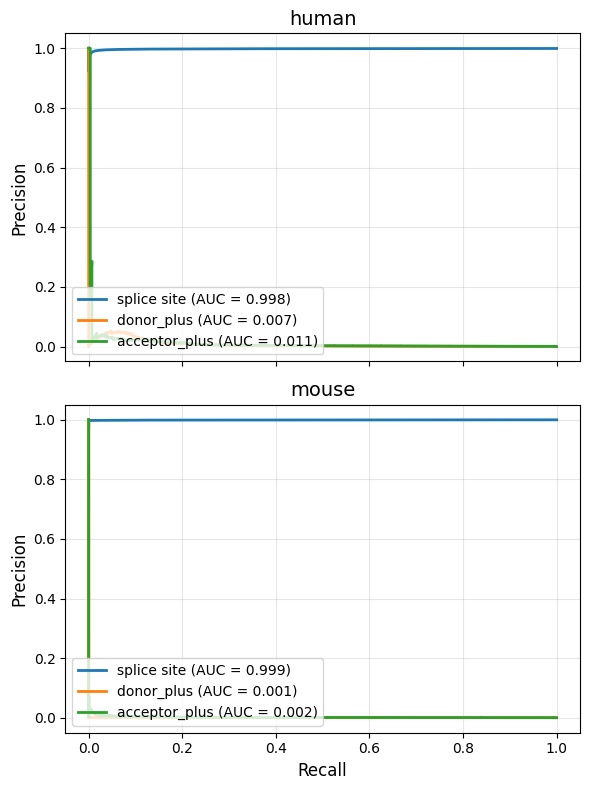

PR-AUC for human splice site: 0.9981
PR-AUC for human donor_plus: 0.0071
PR-AUC for human acceptor_plus: 0.0108
PR-AUC for mouse splice site: 0.9986
PR-AUC for mouse donor_plus: 0.0008
PR-AUC for mouse acceptor_plus: 0.0021


In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
class_labels = {0: 'splice site', 1: 'donor_plus', 2: 'acceptor_plus'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

num_cols = 1
num_rows = len(pr_data)
fig, axs = plt.subplots(2, 1, figsize=(num_cols * 4, num_rows * 4), sharex=True)
org_names = ['human', 'mouse']

for ax_idx, org_name in enumerate(org_names):
    ax = axs[ax_idx]
    if org_name not in pr_data:
        continue

    for class_idx in range(3):
        color = class_colors[class_idx]
        label = class_labels[class_idx]
        if class_idx == 0:
            y_true = pr_data[org_name]['splice_site']['true']
            y_scores = pr_data[org_name]['splice_site']['pred']
        else:
            y_true = pr_data[org_name][class_labels[class_idx]]['true']
            y_scores = pr_data[org_name][class_labels[class_idx]]['pred']

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)
        pr_auc_scores[(org_name, class_idx)] = pr_auc

        ax.plot(
            recall, precision,
            label=f"{label} (AUC = {pr_auc:.3f})",
            linewidth=2,
            color=color
        )

    ax.set_title(f"{org_name}", fontsize=14)
    ax.set_ylabel("Precision", fontsize=12)
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)

axs[-1].set_xlabel("Recall", fontsize=12)
plt.tight_layout()
plt.show()

for (org_name, c), auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {org_name} {class_labels[c]}: {auc_score:.4f}")


Splice usage predictions for entire test dataset.

In [65]:
usage_vals = {}

for org_idx in [0, 1]:  # human=0, mouse=1

    # Get organism name
    org_name = [name for name, idx in species_mapping.items() if idx == org_idx][0]
    
    # Get sequences for this organism
    org_mask = (all_ground_truth['organism_index'] == org_idx).cpu().numpy()
    
    if org_mask.sum() == 0:
        print(f"\nNo sequences for {org_name}")
        continue
    
    print(f"\n{org_name} ({org_mask.sum()} sequences):")

    # Splice usage prediction
    if len(all_predictions[org_name]['splice_usage']) > 0:
        splice_usage_pred = all_predictions[org_name]['splice_usage'][org_mask].numpy()
        
        # Get the SSE columns for this organism
        sse_columns = organism_context_indices[org_name]
        splice_usage_true = all_ground_truth['splice_usage'][org_mask][:, :, sse_columns].numpy()
        
        # Calculate correlation at true splice sites only
        org_splice_labels = all_ground_truth['splice_labels'][org_mask].numpy()
        donor_sites = (org_splice_labels == 1) | (org_splice_labels == 3)
        acceptor_sites = (org_splice_labels == 2) | (org_splice_labels == 4)
        all_sites = donor_sites | acceptor_sites
        
        if all_sites.sum() > 0:
            usage_pred_at_sites = splice_usage_pred[all_sites].flatten()
            usage_true_at_sites = splice_usage_true[all_sites].flatten()
            
            valid_mask_sites = ~(np.isnan(usage_pred_at_sites) | np.isnan(usage_true_at_sites))
            usage_pred_sites_valid = usage_pred_at_sites[valid_mask_sites]
            usage_true_sites_valid = usage_true_at_sites[valid_mask_sites]
            
            # Return for plotting later
            usage_vals[org_name] = {
                "pred": usage_pred_sites_valid, 
                "true": usage_true_sites_valid
            }

            if len(usage_pred_sites_valid) > 1:
                pearson_sites, _ = pearsonr(usage_pred_sites_valid, usage_true_sites_valid)
                spearman_sites, _ = spearmanr(usage_pred_sites_valid, usage_true_sites_valid)
                print(f"Splice usage at true splice sites (n={len(usage_pred_sites_valid):,}):")
                print(f"  Pearson:  {pearson_sites:.4f}")
                print(f"  Spearman: {spearman_sites:.4f}")



human (190 sequences):
Splice usage at true splice sites (n=4,186):
  Pearson:  0.0037
  Spearman: -0.0023

mouse (3429 sequences):
Splice usage at true splice sites (n=99,128):
  Pearson:  0.0233
  Spearman: 0.0306


Make a dataframe with all predictions and true values for splice usage.

In [75]:
import pandas as pd

all_data_df = pd.DataFrame({
    'pred_SSE': np.concatenate([usage_vals[org]['pred'] for org in usage_vals]),
    'true_SSE': np.concatenate([usage_vals[org]['true'] for org in usage_vals]),
    'species': np.concatenate([np.array([org] * len(usage_vals[org]['pred'])) for org in usage_vals])
})

all_data_df

,pred_SSE,true_SSE,species
0,9.999195e-01,1.000,human
1,9.991537e-01,1.000,human
2,9.119620e-01,0.000,human
3,9.866875e-01,1.000,human
4,9.999353e-01,1.000,human
...,...,...,...
103309,1.081919e-04,0.667,mouse
103310,2.382945e-02,0.636,mouse
103311,1.627747e-09,0.000,mouse
103312,4.553158e-03,0.800,mouse


Functions to plot predicted vs true splice usage values.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_sse_density(
        all_data_df: pd.DataFrame, group: str, 
        log_fn=print, 
        max_points_per_group=10000, 
        thresh=0.05
    ):
        """Plot density of predicted vs true SSE values.
        Args:
            all_data_df: DataFrame with SSE data
            group: Column name or list of column names to group by
            output_dir: Directory to save output
            log_fn: Logging function
            max_points_per_group: Maximum points to use for KDE (for speed)
            thresh: Threshold for KDE plot to skip low-density regions
        """
        log_fn("Plotting SSE density...")
        group_name = '_'.join(group) if isinstance(group, list) else group

        if isinstance(group, list):
            log_fn(f"Grouping by multiple columns: {group}")
            all_data_df['group'] = all_data_df[group].astype(str).agg('_'.join, axis=1)
            group = 'group'
        else:
            log_fn(f"Grouping by single column: {group}")

        samples = all_data_df[group].unique()
        num_tissues = len(samples)
        log_fn(f"Found {num_tissues} unique groups to plot")

        num_cols = 1
        num_rows = (num_tissues + num_cols - 1) // num_cols

        log_fn(f"Creating figure with {num_rows} rows and {num_cols} columns")
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), squeeze=False)

        # Collect legend handles from first plot
        legend_handles = []
        legend_labels = []

        for i, tissue in enumerate(samples):
            log_fn(f"Processing group {i+1}/{num_tissues}: {tissue}")
            tissue_data = all_data_df[all_data_df[group] == tissue]
            log_fn(f"  - Data points: {len(tissue_data)}")

            if len(tissue_data) > max_points_per_group:
                log_fn(f"  - Subsampling to {max_points_per_group} points for faster KDE...")
                tissue_data_plot = tissue_data.sample(n=max_points_per_group, random_state=42)
            else:
                tissue_data_plot = tissue_data

            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]

            r_value = np.corrcoef(tissue_data['true_SSE'], tissue_data['pred_SSE'])[0, 1]
            log_fn(f"  - Correlation: {r_value:.4f}")

            # 2D density plot with optimized parameters
            log_fn(f"  - Creating density plot...")
            kde = sns.kdeplot(
                x=tissue_data_plot['true_SSE'],
                y=tissue_data_plot['pred_SSE'],
                levels=5,
                fill=True,
                cmap="rocket_r",
                thresh=thresh,
                bw_adjust=0.8,
                ax=ax,
                label='Density (KDE)' if i == 0 else None
            )

            # Top histogram (True SSE) - use full data
            log_fn(f"  - Creating histograms...")
            ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
            ax_histx.hist(tissue_data['true_SSE'], bins=30, color='gray', alpha=0.7)
            ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

            # Right histogram (Pred SSE) - use full data
            ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
            ax_histy.hist(tissue_data['pred_SSE'], bins=30, orientation='horizontal', color='gray', alpha=0.7)
            ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

            mean_true = tissue_data['true_SSE'].mean()
            mean_pred = tissue_data['pred_SSE'].mean()
            log_fn(f"  - Mean true SSE: {mean_true:.4f}, Mean pred SSE: {mean_pred:.4f}")
            line_true = ax.axvline(mean_true, color='red', linestyle='--', linewidth=1, label='Mean True')
            line_pred = ax.axhline(mean_pred, color='red', linestyle='--', linewidth=1, label='Mean Pred')

            ax.text(0.05, 0.95, f'r = {r_value:.3f}', 
                    transform=ax.transAxes, fontsize=12, fontweight='bold',
                    verticalalignment='top')

            ax.set_title(tissue, fontsize=12, fontweight='bold')
            ax.set_xlabel('True SSE', fontsize=10)
            ax.set_ylabel('Predicted SSE', fontsize=10)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.grid()

        log_fn("Finalizing plot...")

        plt.tight_layout()
        plt.show()

Plotting SSE density...
Grouping by single column: species
Found 2 unique groups to plot
Creating figure with 2 rows and 1 columns
Processing group 1/2: human
  - Data points: 4186
  - Correlation: 0.0037
  - Creating density plot...
  - Creating histograms...
  - Mean true SSE: 0.4588, Mean pred SSE: 0.9707
Processing group 2/2: mouse
  - Data points: 99128
  - Subsampling to 10000 points for faster KDE...
  - Correlation: 0.0233
  - Creating density plot...
  - Creating histograms...
  - Mean true SSE: 0.5898, Mean pred SSE: 0.0173
Finalizing plot...


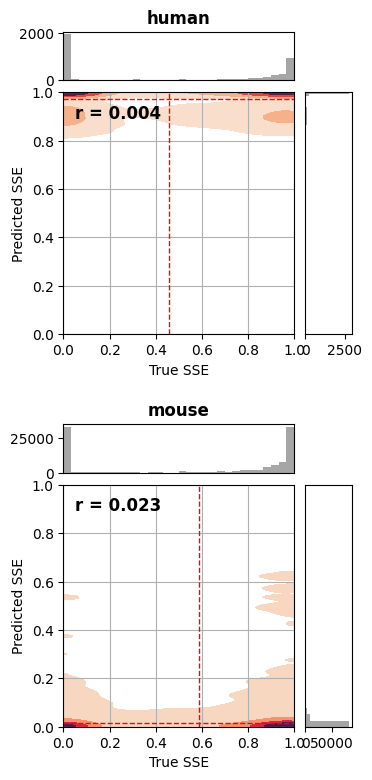

In [89]:
%matplotlib inline

plot_sse_density(
    all_data_df, 
    group='species',
    max_points_per_group=10000, 
    thresh=0.01
)